# Calculation of the resonant scattering
The following calculation is done using an approximation introduced by Stuhrmann

## Libraries

In [148]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

## Job parameters

In [206]:
# give the metadada directory
data_dir = 'files\Data_for_ASAXS\Corrected_1D\\223_TestPorod'

# give the target file tyle:
target_file_type = '_c0_Sub.dat'

# enter the experimental Energies and X-ray attenuation coefficiants 
# in an exported ASCII file (True) or in this sctript (False)
enter_values_external = False

# ending for export file name containing energies and X-ray attenuatino coefficiants
export_file_name_ending = '_AttenuationCoefficiants.txt'
inport_file_name_ending = '_AttenuationCoefficiants_Complete.txt'

# q-binning for resonant calculation
bin_number=400

# Nessesary information to calculate the Resonant
list_FileEntries = ['Energy','dEnergy','f0','f-Real','f-Imagin']
list_Energy=[10000, 7000, 8004, 8239, 8304, 8324, 8330, 8973]
list_dEnergy=[1667, -1333, -329, -94, -29, -9, -3, 640]
list_f0=[28, 28, 28, 28, 28, 28, 28, 28]
list_fReal=[0.0, 0.0, -2.86, -4.11, -5.35, -6.63, -7.87, 0.0]
list_fImagin=[0.0, 0.0, 0.514, 0.489, 0.492, 0.541, 0.741, 0.0]

# Job
## Search the directory

In [207]:
# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith(target_file_type) and entry.is_file():
        fileList.append(entry.path)

fileIterator = iter(fileList)
startFrame=pd.DataFrame()
for element in fileIterator: 
    startFrame = startFrame.append({'FileName':element.split(os.sep)[-1]},ignore_index=True)
if enter_values_external == True:
    for entry in list_FileEntries:
        startFrame[entry] = 'NaN'
    save_outPut_name = data_dir+os.sep+data_dir.split(os.sep)[-1]+export_file_name_ending
    startFrame.to_csv(save_outPut_name, sep='\t')
    print('File to enter values manualle exported to:',data_dir)
elif enter_values_external == False:
    startFrame['Energy']=list_Energy
    startFrame['dEnergy']=list_dEnergy
    startFrame['f0']=list_f0
    startFrame['f-Real']=list_fReal
    startFrame['f-Imagin']=list_fImagin
    print('Attenuation values completed from lists given above')
    pass
else:
    print('Enter True or False for >enter_values_external<')

Attenuation values completed from lists given above


## ReLoad the file containing the attenuation parameters

In [208]:
if enter_values_external == True:    
    #read the meta file
    path_toFile = data_dir+os.sep+data_dir.split(os.sep)[-1]+inport_file_name_ending 
    dF = pd.read_csv(path_toFile, sep='\t',index_col=0)
    print('Data is collected from:',data_dir)
elif enter_values_external==False:
    dF = startFrame
    print('Attenuation values completed from lists given above')
else:
    print('Enter True or False for >enter_values_external<')

Attenuation values completed from lists given above


## Select the data to use for resonant calculations

In [209]:
indexSet_Resonant = {3,4,5}
dF_set=dF.loc[indexSet_Resonant]
dF_set=dF_set.sort_values('Energy', axis=0, ascending=True, kind='quicksort').reset_index(drop=True)

In [210]:
q=[]
I=[]
e=[]
for index in dF_set.index:
    pathToData=data_dir+os.sep+dF_set['FileName'][index]
    q_inp, I_inp, e_inp = np.genfromtxt(pathToData,skip_header=0,unpack=True)
    q.append(q_inp)
    I.append(I_inp)
    e.append(e_inp)
    print(dF_set['FileName'][index])

223_8239.0_eV_Tif_419_Norm_c0_Sub.dat
223_8304.0_eV_Tif_437_Norm_c0_Sub.dat
223_8324.0_eV_Tif_455_Norm_c0_Sub.dat


[]

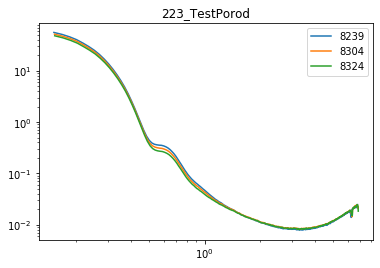

In [211]:
fig, ax = plt.subplots()
ax.plot(q[0], I[0],label=dF_set['Energy'][0])
ax.plot(q[1], I[1],label=dF_set['Energy'][1])
ax.plot(q[2], I[2],label=dF_set['Energy'][2])
plt.title(data_dir.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
plt.legend()
ax.loglog()

In [212]:
q_min=max(min(q[0]),min(q[1]),min(q[2]))
q_max=min(max(q[0]),max(q[1]),max(q[2]))
ind_q0_min=min(range(q[0].size), key=lambda i: abs(q[0][i]-q_min))
ind_q0_max=min(range(q[0].size), key=lambda i: abs(q[0][i]-q_max))
ind_q1_min=min(range(q[1].size), key=lambda i: abs(q[1][i]-q_min))
ind_q1_max=min(range(q[1].size), key=lambda i: abs(q[1][i]-q_max))
ind_q2_min=min(range(q[2].size), key=lambda i: abs(q[2][i]-q_min))
ind_q2_max=min(range(q[2].size), key=lambda i: abs(q[2][i]-q_max))
print(len(q[0]),len(q[1]),len(q[2]),ind_q0_min,ind_q1_min,ind_q2_min,ind_q0_max,ind_q1_max,ind_q2_max)

400 400 400 0 0 0 399 396 395


[]

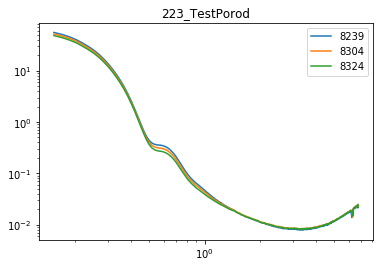

In [213]:
f0 = interp1d(q[0], I[0], kind='cubic')
f1 = interp1d(q[1], I[1], kind='cubic')
f2 = interp1d(q[2], I[2], kind='cubic')

f0 = interp1d(q[0], I[0])
f1 = interp1d(q[1], I[1])
f2 = interp1d(q[2], I[2])

q_new = np.linspace(q_min, q_max, num=bin_number, endpoint=True)

fig, ax = plt.subplots()
ax.plot(q_new, f0(q_new),label=dF_set['Energy'][0])
ax.plot(q_new, f1(q_new),label=dF_set['Energy'][1])
ax.plot(q_new, f2(q_new),label=dF_set['Energy'][2])
plt.title(data_dir.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
plt.legend()
ax.loglog()

[]

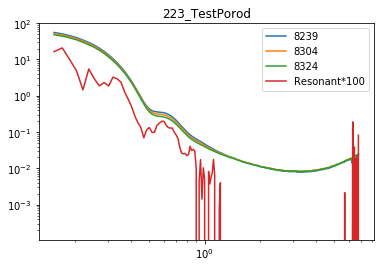

In [216]:
Ires_T1=dF_set['f-Real'][2]*(f0(q_new)-f1(q_new))+dF_set['f-Real'][0]*(f1(q_new)-f2(q_new))+dF_set['f-Real'][1]*(f2(q_new)-f0(q_new))
Ires_T2=(dF_set['f-Real'][0]-dF_set['f-Real'][1])*(dF_set['f-Real'][0]**2-dF_set['f-Real'][2]**2+dF_set['f-Imagin'][0]**2-dF_set['f-Imagin'][2]**2)
Ires_T3=(dF_set['f-Real'][0]-dF_set['f-Real'][2])*(dF_set['f-Real'][0]**2-dF_set['f-Real'][1]**2+dF_set['f-Imagin'][0]**2-dF_set['f-Imagin'][1]**2)
Ires = Ires_T1 / (+Ires_T2-Ires_T3)

fig, ax = plt.subplots()
ax.plot(q_new, f0(q_new),label=dF_set['Energy'][0])
ax.plot(q_new, f1(q_new),label=dF_set['Energy'][1])
ax.plot(q_new, f2(q_new),label=dF_set['Energy'][2])
ax.plot(q_new, Ires*100,label='Resonant*100')
plt.title(data_dir.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
plt.legend()
ax.loglog()

In [215]:
dF_set

,FileName,Energy,dEnergy,f0,f-Real,f-Imagin
0,223_8239.0_eV_Tif_419_Norm_c0_Sub.dat,8239,-94,28,-4.11,0.489
1,223_8304.0_eV_Tif_437_Norm_c0_Sub.dat,8304,-29,28,-5.35,0.492
2,223_8324.0_eV_Tif_455_Norm_c0_Sub.dat,8324,-9,28,-6.63,0.541
